<a href="https://colab.research.google.com/github/Yeoonsu/PythonPractice/blob/main/Pytorch_FashionMNIST_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Module Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
# 3. FashionMNIST 데이터 다운로드(Train set, Test set 분리하기)
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [7]:
# 4. 데이터 확인하기 (1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


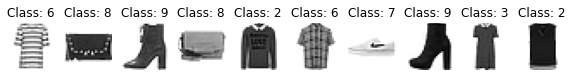

In [8]:
# 5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
  plt.title('Class: ' + str(y_train[i].item()))

In [9]:
# 6. AutoEncode(AE) 모델 설계하기
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28*28),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [10]:
# 7. Optimizer, Objective Function 설정하기
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [11]:
# 8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, _) in enumerate(train_loader):
    image = image.view(-1, 28*28).to(DEVICE)
    target = image.view(-1, 28*28).to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(image)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image),
                                                                          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                          loss.item()))

In [12]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  real_image = []
  gen_image = []
  with torch.no_grad():
    for image, _ in test_loader:
      image = image.view(-1, 28*28).to(DEVICE)
      target = image.view(-1, 28*28).to(DEVICE)
      encoded, decoded = model(image)

      test_loss += criterion(decoded, image).item()
      real_image.append(image.to("cpu"))
      gen_image.append(decoded.to("cpu"))

  test_loss /= len(test_loader.dataset)
  return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.016306
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.015722
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.018254
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.014673
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.013924
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.014130
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.011682
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.013130
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.012354
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.012237

[EPOCH: 1], 	Test Loss: 0.0004


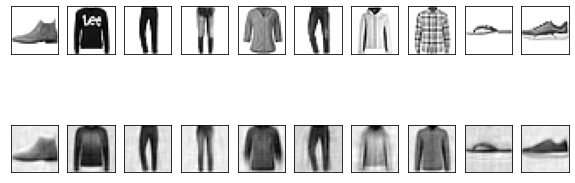

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.014173
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.012549
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.011343
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.011842
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.011397
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.011661
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.011271
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.015722
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.011862
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.012725

[EPOCH: 2], 	Test Loss: 0.0004


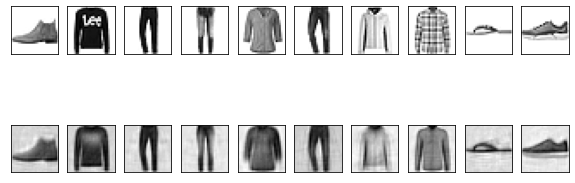

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.011828
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.008593
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.010470
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.013640
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.010125
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.012272
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.013927
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.009371
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.009813
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.011380

[EPOCH: 3], 	Test Loss: 0.0004


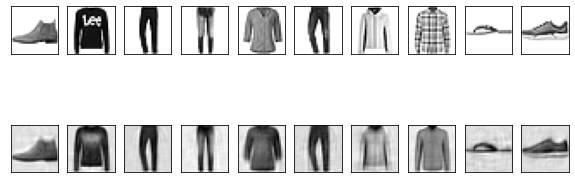

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.011957
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.010709
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.009776
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.010221
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.013563
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.009482
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.012569
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.010918
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.009067
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.009688

[EPOCH: 4], 	Test Loss: 0.0003


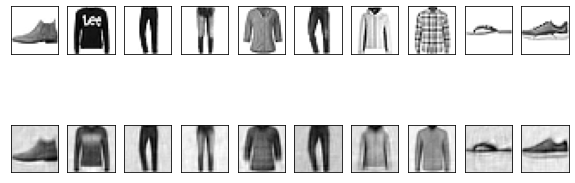

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.010841
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.009731
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.011628
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.011133
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.013258
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.008681
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.009413
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.011327
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.010636
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.009449

[EPOCH: 5], 	Test Loss: 0.0003


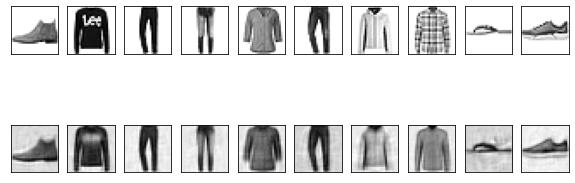

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.009293
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.009198
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.009336
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.011151
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.011747
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.009796
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.009918
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.008791
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.011073
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.010076

[EPOCH: 6], 	Test Loss: 0.0003


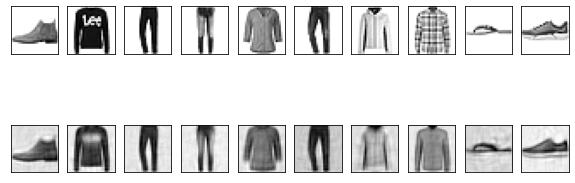

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.007976
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.010577
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.013930
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.007815
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.009453
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.010307
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.008416
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.009108
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.009947
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.011726

[EPOCH: 7], 	Test Loss: 0.0003


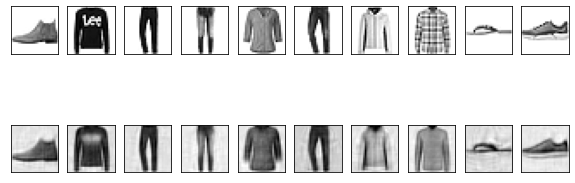

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.011599
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.010754
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.008753
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.010806
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.009661
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.012585
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.009540
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.011560
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.012212
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.010443

[EPOCH: 8], 	Test Loss: 0.0003


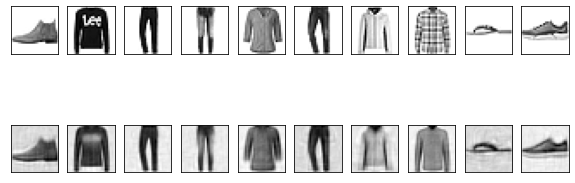

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.010987
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.010819
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.010207
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.009241
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.011387
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.009475
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.008371
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.008007
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.009867
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.010012

[EPOCH: 9], 	Test Loss: 0.0003


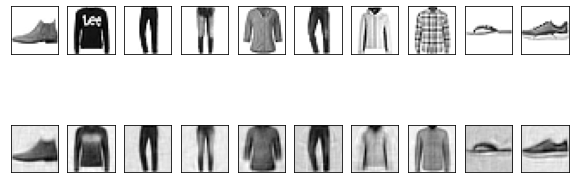

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.011686
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.008090
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.009096
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.009425
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.011616
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.010880
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.008907
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.009117
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.010321
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.009296

[EPOCH: 10], 	Test Loss: 0.0003


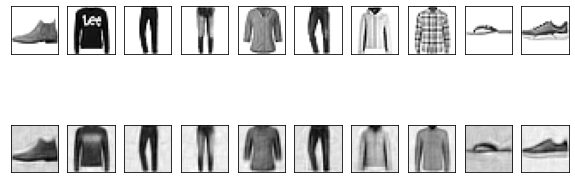

In [15]:
# 10. AutoEncoder 학습을 실행하며 Test set의 Reconstruction Error 확인하기
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, real_image, gen_image = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))
  f, a = plt.subplots(2, 10, figsize =(10, 4))
  for i in range(10):
    img = np.reshape(real_image[0][i],(28, 28))
    a[0][i].imshow(img, cmap = "gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

  for i in range(10):
    img = np.reshape(gen_image[0][i],(28, 28))
    a[1][i].imshow(img, cmap = "gray_r")
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
  plt.show()